#Melanoma image classification webapp

For the web app homework application I want to make a melanoma classifier. For this project I use an existing dataset from kaggle:
https://www.kaggle.com/drscarlat/melanoma

I didn't check the data yet, I first want to try if it works.
I am going to use a resnet34 convoltional network.

Start by the several lines that are needed to: Update the fastai library, import it and set some inline code.

##Setup and download the dataset

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install --upgrade git+https://github.com/fastai/fastai.git

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
torch.backends.cudnn.benchmark = True

# Sets the batch-size; If your GPU cant handle it, lower the batch-size.
bs = 64

Updating fastai...
Done.
  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-xvm04eby
  Stored in directory: /tmp/pip-ephem-wheel-cache-356z9ueg/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
Successfully built fastai
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51


Since it is easier to download the dataset directly, we have to set-up our system so that is able to download it via this workbook. I used this helpfull stackoverflow post: https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab


In [0]:
#Install kaggle-cli
pip install -q kaggle

In [0]:
#Upload your kaggle.json file; This is your api key
from google.colab import files
files.upload()

In [0]:
#Move file to ~/.kaggle, your api file is supposed to be there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
#Download the dataset
!kaggle datasets download -d drscarlat/melanoma

100% 2.62G/2.63G [00:25<00:00, 114MB/s] 
100% 2.63G/2.63G [00:25<00:00, 113MB/s]


In [0]:
!unzip -o -q /content/melanoma.zip

In [0]:
mv /content/DermMel/train_sep /content/DermMel/train/

##Train the model

For this project we are going to train a Resnet34 model. But first we need to make a databunch object.

In [0]:
#Create the databunch object
path = "/content/DermMel/"
data = ImageDataBunch.from_folder(path,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=bs).normalize(imagenet_stats)

Look at some data to determine if it was succesfull.

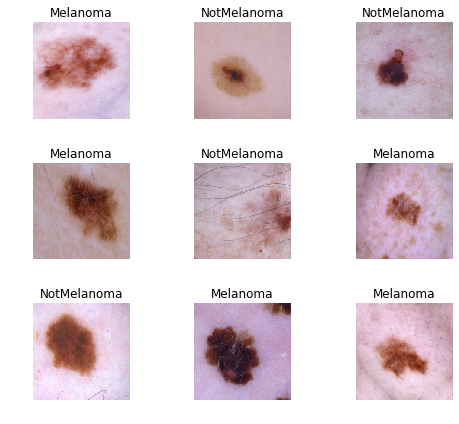

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
data.classes

['Melanoma', 'NotMelanoma']

Train the model using the Resnet34 convulational neural network.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 76618288.48it/s]


In [0]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,0.251882,0.166649,0.065132,03:41
1,0.175624,0.141839,0.052499,03:42
2,0.158935,0.133929,0.049691,03:44
3,0.145468,0.131659,0.048568,03:42


In [0]:
learn.save('stage-1')

##Interpret Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

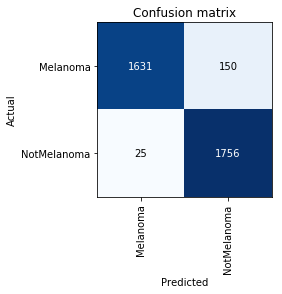

In [0]:
interp.plot_confusion_matrix()

##Cleaning up

I don't think I am classified to clean up the data, since I am no expert dermatologist. It ois better to make sure that the data is from a reliable source.

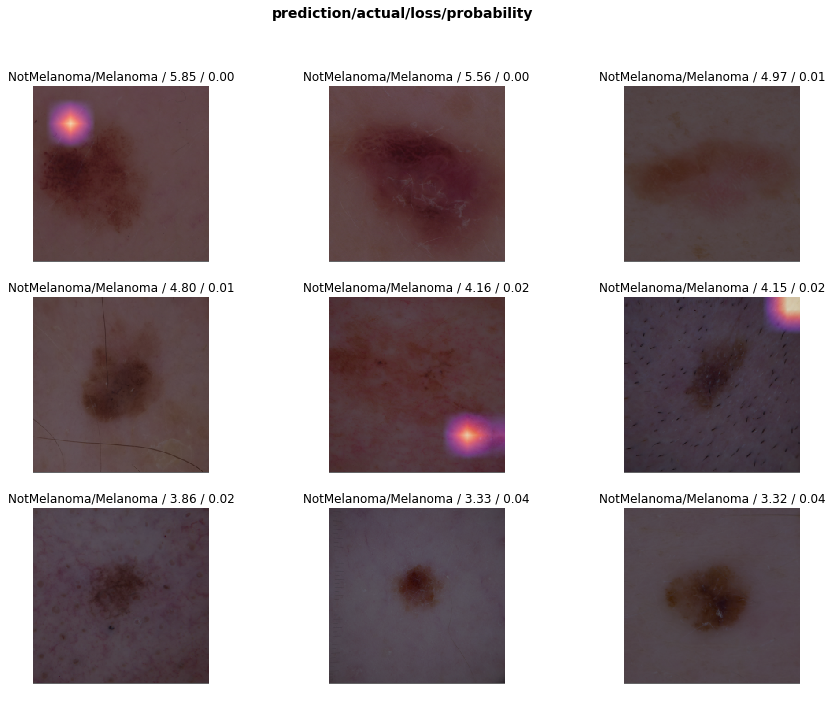

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

##Unfreezing

Let's try to see if this can improve the model.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.153703,0.123969,0.049972,03:46


Find the "correct" learning rate

I still have some doubt if I determine the learning rate correctly.

In [0]:
learn.load('stage-1')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


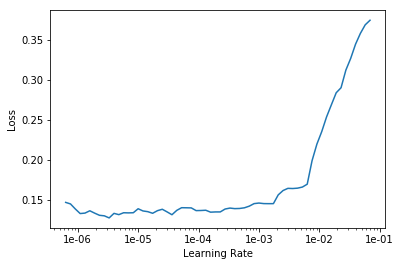

In [0]:
learn.recorder.plot()

I trained this model twice, the first time there was no overfitting (based on the error_rate not becoming higher). However, the second time it seems to overfit. Maybe there is a solution for that?

In [0]:
learn.unfreeze()
#Maybe I can fit more cycles, since there is no overfitting yet. However, do we want that. Ok, I'll try 6 cycles now.
learn.fit_one_cycle(6, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.142170,0.128927,0.049410,03:45
1,0.137405,0.119109,0.042673,03:50
2,0.118577,0.117386,0.043515,03:50
3,0.109523,0.114549,0.041830,03:43
4,0.096223,0.114692,0.044357,03:45
5,0.087115,0.114497,0.042392,03:43


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

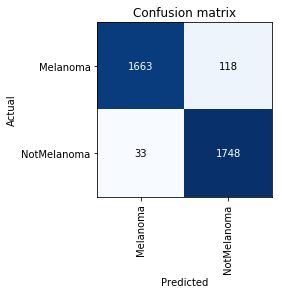

In [0]:
interp.plot_confusion_matrix()

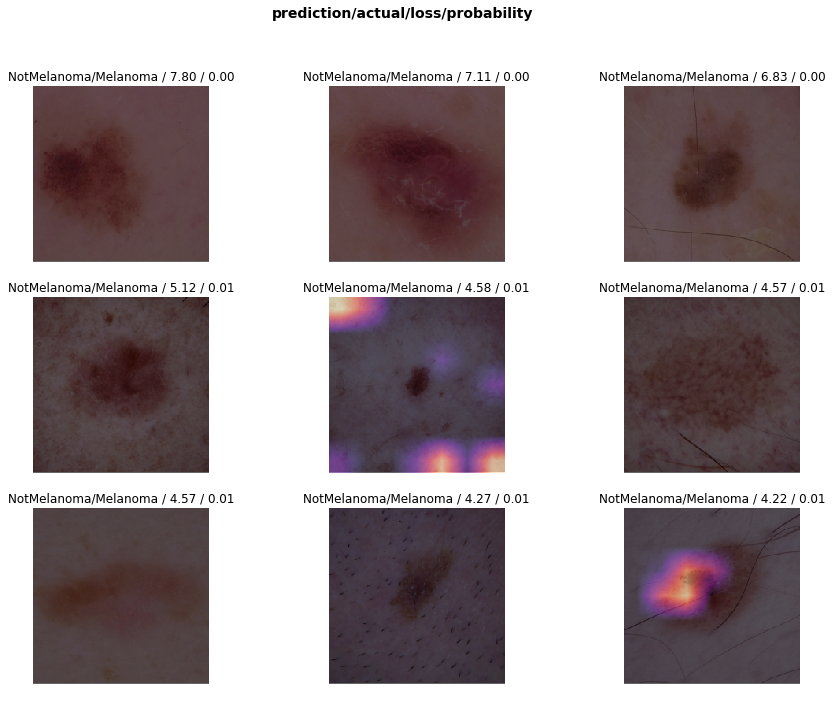

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
learn.export()

##Improvements

This is my second project (I am still finishing the first project). I already felt more comfortable using the fast.ai library. However, there is still room for improvement.

* Making sure the training data is trustworthy, since I am no dermatologist
* Maybe using resnet50 instead of resnet34
* Using other transforms (maybe just like the satellite in lesson 3, for this problem I can use vertical flips?)
* And in lesson 3 there was a part about picture sizes, maybe that also can help this model. However, I didn't fully understood it yet. 
* Improving the learning rate
* Change the number of epochs.


## Difficulties

During this project I had several difficulties challenges that I would like to share with you.
* Finding a trustworthy dataset (I was not able to find the source of these pictures)
* I am no dermatologist so it is hard for me to verify the data.
* Making the web-application. My only experience is using Flask in the cs50 course I followed online via Edx. However, the most problamatic part was deploying the model on a hosting site. After a lot of tries I was finally able to launch the app on Heroku.

* I am not able to run the code lokally yet, so I had to upload it to Heroku to check if it worked. This takes quite some time, so honestly, I should try to install the necessary programs locally. Since I don't have NVIDIA graphics card, so don't have CUDA, I for some reason was not able to install the fastai library (even using the pytorch cpu only library)

* First time using Heroku: needed to change the Procfile, but I didn't know how. I found out that for web application you need this line: 

In [0]:
web: gunicorn application:app

* And you should rename *application* to your filename that creates the Flask instance, and *app* to the name you gives this Flask instance in your *application*  file.
* Lastly, I got a problem: Unexpected key(s) in state_dict. This seems to be a problem with different fastai library versions you use for learning the model, and making predictions in your web app. So you have to make sure you use the same fastai library versions.

##Production

So I am now planning to make a web application with flask, to clasify images that you can send in via an image or an url.

https://melanoma-classifier.herokuapp.com/

You can find the files here:

https://github.com/Mees-Molenaar/melanoma-classifier

## Code Used

I used some coding examples for this project from different sources:
* Flask documentation
* Fastai course
* Bootstrap documentation
* CS50 course
* Simon W's Cougar or not project.